# Previsão Idade VGGFace

Neste notebook será abordado novamente o problema de estimação de idade, utilizando agora a rede VGGFace. Tal como nos notebooks passados, é preciso, numa fase inicial, carregar os dados dos ficheiros previamente criados. De seguida será feita a separação dos dados para treino/teste e por fim testar-se-á o sucesso da rede. Para tal usaremos não só a métrica da accuracy como de 1Off (ou seja, qual a percentagem de acertar no bin correto ou num diretamente adjacente a este, +/-1).

### Imports necessários

In [1]:
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
from PIL import Image


## Recuperação dos dados dos ficheiros relativamente às imagens/labels

Leitura do ficheiro csv correspondente a todas as labels e anexação destas à lista results

In [2]:
import csv
results = []
with open("C:/Users/pg41843/Desktop/5kLabelsNoBins.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_ALL) # change contents to floats
    for row in reader: # each row is a list
        results.append(row)

Processamento das idades e conversão destas para os respetivos bins.
Tal como referido anteriormente estes bins seguem a distribuição normal dos dados do dataset

In [3]:
labelslist = []
label =""
for i in range(len(results)):
    age = int(results[i][0])
    if(age>=18 and age<=21):
        label = "18_21"
    if(age>=22 and age<=24):
        label = "22_24"
    if(age>=25 and age<=28):
        label = "25_28"
    if(age>=29 and age<=33):
        label = "29_33"
    if(age>=34 and age<=40):
        label = "34_40"
    if(age>=41 and age<=47):
        label = "41_47"
    if(age>=48 and age<=55):
        label = "48_55"
    if(age>=56 and age<=65):
        label = "56_65"
    labelslist.append(label)

In [4]:
labels = np.reshape(labelslist,len(labelslist))
len(labels)

5642

Leitura do ficheiro relativo aos pontos das fotos.

Neste caso foi utilizado o que possuía metade da informação do dataset (13877 fotos).
Este foi guardado num ficheiro binário por uma questão de redução de dimensão (uma vez que este contém 5642 * 256 * 256 floats)


In [5]:
teste = np.reshape( np.fromfile("C:/Users/pg41843/Desktop/5kDataNoBins"),(len(labels),256,256))

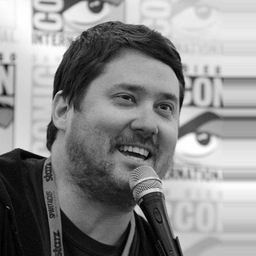

In [6]:
#Verificação da integridade dos dados -> foto reconstruível através dos pontos 
image2 = Image.fromarray((teste[20]*255).astype('uint8'))
image2

## Divisão dos dados para treino e teste

Uma vez que é necessária uma divisão do dataset para treino e teste, utilizamos o train_test_split com a flag de stratify (garantindo que a distribuição dos dados se mantém nas versões "reduzidas") e com random_state, permitindo assim que a operação se torne determinística (os mesmos dados irão ser divididos sempre para os mesmos conjuntos de treino e teste, enquanto que o valor desta flag se mantenha constante)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(teste,labels, test_size=0.15, stratify=labels,random_state = 2)

Uma vez dividido os dados, precisamos de os pré-processar antes de os dar à rede. Deste modo convertemos as labels dos dados em one-hot-encondig, correspondendo assim a um array de dimensão 8 (número de classes) com um 1 no índice da classe correspondente.

In [8]:
#1Hot encoding para as labels de treino
train_labels = pd.get_dummies(y_train)
test_labels = pd.get_dummies(y_test)

In [9]:
#1Hot encoding para as labels de teste
train_labels = train_labels.to_numpy()
test_labels = test_labels.to_numpy()

Conversão dos dados das fotos para as dimensões corretas, de modo a ser possível passa-los à rede

In [10]:
#Reshape para 4 dimensões (nFotos * 256pixeis * 256 pixeis * 1 canal de cor(black&white))
train_images = X_train.reshape((len(X_train), 256, 256, 1))
test_images = X_test.reshape((len(X_test), 256, 256, 1))

## Criação e treino da rede

Tendo todos os dados carregados e prontos para passar à rede, podemos seguir para a contrução e treino da mesma. Assim, neste notebook, tal como referido anteriormente, utilizaremos a rede VGGFace. Esta pode ser definida através do import keras_vggface.vggface e a sua posterior invocação VGGFace()

In [14]:
import tensorflow as tf
import skimage.io as io
from tensorflow.keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout
from  keras_vggface.vggface import VGGFace



model = VGGFace()
model.summary()

Using TensorFlow backend.


580075520/580070376 [==============================] - 37s 0us/step
Model: "vggface_vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
___________________________________________________

Como se pode ver acima, este rede não recebeu qualquer argumento, assim ter-se-á de mudar a primeira e a última camada, de modo a que os input/output size fiquem corretos para o problema em questão. Deste modo o comando seguinte altera o input_size de (224,224,3), imagem de 224 * 224 pixeis a cores, para (256,256,1), imagem de 256 * 256 a preto e branco

In [15]:
import keras
def change_model(model, new_input_shape=(None,40,40,3)):
    i = 0
    model.layers[0].batch_input_shape = new_input_shape
    new_model = keras.models.model_from_json(model.to_json())
    for layer in new_model.layers:
        try:
            layer.set_weights(model.get_layers(name=layer.name).get_weights())
            print("Loaded layer {}".format(layer.name))
        except:
            i=i+1
            print("Could not transfer weights for layers {}".format(layer.name))
    print(i)
    return new_model

new_model = change_model(model,new_input_shape=(None, 256, 256, 1))
#new_model.summary()

Could not transfer weights for layers input_1
Could not transfer weights for layers conv1_1
Could not transfer weights for layers conv1_2
Could not transfer weights for layers pool1
Could not transfer weights for layers conv2_1
Could not transfer weights for layers conv2_2
Could not transfer weights for layers pool2
Could not transfer weights for layers conv3_1
Could not transfer weights for layers conv3_2
Could not transfer weights for layers conv3_3
Could not transfer weights for layers pool3
Could not transfer weights for layers conv4_1
Could not transfer weights for layers conv4_2
Could not transfer weights for layers conv4_3
Could not transfer weights for layers pool4
Could not transfer weights for layers conv5_1
Could not transfer weights for layers conv5_2
Could not transfer weights for layers conv5_3
Could not transfer weights for layers pool5
Could not transfer weights for layers flatten
Could not transfer weights for layers fc6
Could not transfer weights for layers fc6/relu
C

Todavia ainda é necessário mudar a layer de output, para o número de classes deste problema. Assim, removemos a última camada e adicionámos uma camada Dense com 8 neurónios (número de classes possíveis para a rede prever => bins da idade)

In [16]:
import numpy as np
import tensorflow.keras

x2 = new_model.get_layer("fc8").input
x2 = keras.layers.Dense(units=8, name="fc8/softmax", activation="softmax")(x2)
modelVGG = keras.models.Model(inputs=new_model.input, outputs=x2)


Como se pode ver pela imagem abaixo, temos agora uma rede adaptada para o problema em questão, podendo assim passar-se ao treino e teste da mesma

In [17]:
#net2.add(layers.Dense(64, activation=activations.relu))
modelVGG.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 1)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 256, 256, 64)      640       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 256, 256, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 128, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 128, 128, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 64, 64, 128)       0   

Definição das métricas do modelo, "standard" para este problema de classificação

In [18]:
modelVGG.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])




Neste ponto, somos capazes de treinar a rede, todavia este é um processo lento e computacionalmente pesado. Assim, consideramos mais seguro e eficiente, a cada X epochs (3 neste caso) gravar o modelo. Deste modo, caso o kernel morra ou a conexão se perca (e.g., ligação ao colab ou a centro de processamento) pode-se carregar o modelo, até ao momento treinado, e prosseguir para as seguintes epochs. 

Uma vez que o número de dados é "reduzido" (11k fotos) consideramos que um batch size pequeno seria benéfico para uma melhor aprendizagem. Por fim consideramos também que com esta abordagem, ser-nos-ia mais fácil contornar o overfitting, uma vez que conseguiríamos aceder a modelos gerados antes de atingir esse ponto (que acaba por piorar a performance da rede)

In [ ]:
for i in range (10):
    modelVGG.fit(train_images, train_labels, epochs=3, batch_size=16)
    modelVGG.save('VGGFface'+str(i)+".h5")

Epoch 1/3
4795/4795 [==============================] - 5632s 1s/step - loss: 2.0667 - accuracy: 0.1660
Epoch 2/3
4795/4795 [==============================] - 5558s 1s/step - loss: 2.0610 - accuracy: 0.1660
Epoch 3/3
4795/4795 [==============================] - 5635s 1s/step - loss: 2.0601 - accuracy: 0.1673
Epoch 1/3
4795/4795 [==============================] - 5586s 1s/step - loss: 2.0596 - accuracy: 0.1681
Epoch 2/3
4795/4795 [==============================] - 5569s 1s/step - loss: 2.0594 - accuracy: 0.1666
Epoch 3/3
4795/4795 [==============================] - 5553s 1s/step - loss: 2.0596 - accuracy: 0.1641
Epoch 1/3
4795/4795 [==============================] - 5563s 1s/step - loss: 2.0592 - accuracy: 0.1681
Epoch 2/3
4795/4795 [==============================] - 5510s 1s/step - loss: 2.0590 - accuracy: 0.1681
Epoch 3/3
4795/4795 [==============================] - 5524s 1s/step - loss: 2.0584 - accuracy: 0.1668
Epoch 1/3
4795/4795 [==============================] - 5522s 1s/step - lo

Como se pode ver pelo resultado acima, os valores de accuracy mantiveram-se constantes durante toda a fase de treino, implicando assim que a rede não foi capaz de aprender nada com os dados. Para verificar que tal ocorreu, passamos à fase de teste, de modo a verificar se este modelo é viável para este problema.

In [13]:
from tensorflow.keras.models import load_model
modelVGG = load_model("C:/Users/pg41843/Desktop/VGGFface3.h5")

In [15]:
test_loss, test_acc = modelVGG .evaluate(test_images, test_labels)

847/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Observando o resultado anterior a accuracy das previsões para as imagens de teste foram bastantes semelhantes com a fase de treino. Assim, podemos concluir que o modelo, tal como previamos, não aprendeu e fez um "palpite" aleatório para cada input.